In [3]:
import requests
import io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq

In [7]:
def get_person_activity(person:str, activity:str):
    """Get dataframe filtered by person and activity
    Args:
        person (str): filter by person
        activity (str): filter by activity

    Returns:
        pd.Dataframe: timestamps on index
    """
    return pd.read_csv(io.StringIO(requests.get(f"http://docker.caracal-lime.ts.net:9000/exp?query=SELECT * FROM prod where person %3D '{person}' and activity %3D '{activity}'").text), parse_dates=['timestamp']).set_index('timestamp', drop=True)

def get_activity(activity:str):
    """Get dataframe filtered by activity
    Args:
        activity (str): filter by activity

    Returns:
        pd.Dataframe: timestamps on index
    """
    return pd.read_csv(io.StringIO(requests.get(f"http://docker.caracal-lime.ts.net:9000/exp?query=SELECT * FROM prod where activity %3D '{activity}'").text), parse_dates=['timestamp']).set_index('timestamp', drop=True)

def get_person(person:str):
    """Get dataframe filtered by person
    Args:
        person (str): filter by person

    Returns:
        pd.Dataframe: timestamps on index
    """
    return pd.read_csv(io.StringIO(requests.get(f"http://docker.caracal-lime.ts.net:9000/exp?query=SELECT * FROM prod where person %3D '{person}'").text), parse_dates=['timestamp']).set_index('timestamp', drop=True)

def get_all():
    """Get dataframe with full data
    Returns:
        pd.Dataframe: timestamps on index
    """
    return pd.read_csv(io.StringIO(requests.get(f"http://docker.caracal-lime.ts.net:9000/exp?query=SELECT * FROM prod").text), parse_dates=['timestamp']).set_index('timestamp', drop=True)

In [4]:
def resample_df(df:pd.DataFrame, fs_resample_Hz:int, interp_method:"str"="linear"):
    """Resample (interpolate) dataframe to a certain frequency
    Args:
        df (pd.DataFrame): dataframe with timestamps on index
    
    Returns:
        resampled pd.DataFrame
    """
    return df.resample(f"{int(1E6/fs_resample_Hz)}us", origin="start").interpolate(method=interp_method)

def get_fft_freqency_spectrum(df:pd.DataFrame):
    """get frequency spectrum from dataframe (column wise)

    Args:
        df (pd.DataFrame): dataframe with timestamps on index

    Returns:
        dict(key: column, value: absolute fft)
    """
    
    #assert constant frequency
    assert (np.diff(df.index.values) == np.diff(df.index.values)[0]).all()

    fs = pd.Timedelta(1, "s") / np.diff(df.index.values)[0] #get sampling frequency

    #generate spectrum from each column
    data = {}
    for col in df.columns:
        N = len(df[col])

        yf = fft(df[col].values)
        xf = fftfreq(N, 1 / fs)

        data[col] = (xf[:N//2], 2.0/N * np.abs(yf[0:N//2]))

    return data

def plot_fft(df:pd.DataFrame, title:str, size=tuple):
    """plots fft from dataframe
    Args:
        df (pd.DataFrame): dataframe with timestamps on index
        title (str): title of plot
        size (tuple): size of plot. example: (30, 10)

    Returns:
        None
    """
    
    data = get_fft_freqency_spectrum(df) #get spectrum

    #plot spectrum
    plt.figure(figsize=size)
    for key, value in data.items():
        plt.plot(value[0], value[1], label=key)
    
    plt.title(title)
    plt.xlabel("frequency [Hz]")
    plt.ylabel("amplitude")
    plt.legend()
    plt.show()

def plot_raw(df:pd.DataFrame, title:str, y_label:str, size=tuple):
    """plots columns with respect to index
    Args:
        df (pd.DataFrame): dataframe with timestamps on index
        title (str): title of plot
        y_label (str): y label of plot
        size (tuple): size of plot. example: (30, 10)

    Returns:
        None
    """

    plt.figure(figsize=size)
    for col in df.columns:
        plt.plot(df.index, df[col], label=col)

    plt.title(title)
    plt.xlabel("time")
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

def segmentate(df:pd.DataFrame, window_len_s:float, overlap_percent:int):
    """Makes windows [aka best os ;)] from dataframe
    Args:
        df (pd.DataFrame): dataframe with timestamps on index
        window_len_s (float): each window has this length in seconds
        overlap_percent (int): percentage of overlap from previous window [0, 100]

    Example window length 4s and 50% overlap:
    
    1. original time series (each number represents a second): |1,2,3,4,5,6,7,8,9,10,11,12,13|
    
    2. use function: segmentate(|1,2,3,4,5,6,7,8,9,10,11,12,13|, 4, 50)

    3. returns: [|1,2,3,4|,|3,4,5,6|,|5,6,7,8|,|7,8,9,10|,|9,10,11,12|]

    Remark: last window (|11,12,13|) wouldn't have full length why this data is ignored

    Returns:
        list of dataframes
    """
    
    overap_timedelta = pd.Timedelta((window_len_s / 100) * overlap_percent, "s")  

    windows = []
    window_start = df.index[0]
    while(True):
        window_end = window_start + pd.Timedelta(window_len_s, "s")

        #window cannot reach full length
        if window_end > df.index[-1]:
            return windows

        windows.append(df.loc[(df.index >= window_start) & (df.index <= window_end)])
        
        window_start = window_end - overap_timedelta

In [13]:
def plot_trunc_res_gravity(df:pd.DataFrame, len_s:float = 60, resample_freq_Hz:int = 50):
    """Plot raw gyro and fft of truncated dataframe
    Args:
        df (pd.DataFrame): dataframe with timestamps on index
        len_s (float): only plot first x seconds of dataframe
        resample_freq_Hz (int): before plotting, resample to x Hz

    Returns:
        None
    """
    
    #plot raw signal
    activity = df["activity"][0]
    person = df["person"][0]

    df_gyro = resample_df(df[["Gravity_x", "Gravity_y", "Gravity_z"]], resample_freq_Hz)
    df_gyro = df_gyro.loc[df_gyro.index <= df_gyro.index[0]+pd.Timedelta(len_s, "s")]

    plot_raw(df_gyro, f"raw signal: {person} {activity} [{resample_freq_Hz}Hz resampled]", "acceleration [m/s^2]", (35,10))

    plot_fft(df_gyro, f"frequency spectrum: {person} {activity} [{resample_freq_Hz}Hz resampled]", (10,10))

def plot_trunc_res_gravtiy_norm(df:pd.DataFrame, len_s = 60, resample_freq_Hz = 50):
    """Plot gyro and fft of truncated and l2 normalized dataframe
    Args:
        df (pd.DataFrame): dataframe with timestamps on index
        len_s (float): only plot first x seconds of dataframe
        resample_freq_Hz (int): before plotting, resample to x Hz

    Returns:
        None
    """

    #plot raw signal
    activity = df["activity"][0]
    person = df["person"][0]

    df_gyro = resample_df(pd.DataFrame(index=df.index, data={"gravity_norm": np.linalg.norm(df[["Gravity_x", "Gravity_y", "Gravity_z"]].to_numpy(), axis=1)}), resample_freq_Hz)
    df_gyro = df_gyro.loc[df_gyro.index <= df_gyro.index[0]+pd.Timedelta(len_s, "s")]

    plot_raw(df_gyro, f"raw signal: {person} {activity} [{resample_freq_Hz}Hz resampled]", "acceleration [m/s^2]", (35,10))

    plot_fft(df_gyro, f"frequency spectrum: {person} {activity} [{resample_freq_Hz}Hz resampled]", (10,10))

# Analyze missing values of gravity

In [15]:
data = get_all()

In [16]:
#gravity missing data in counts as table
data[["Gravity_x", "Gravity_y", "Gravity_z"]].isnull().groupby([data["person"], data["activity"]]).sum()

Gravity_x  Gravity_y  Gravity_z
person          activity                                      
Ben_Tran        Laufen                 0          0          0
                Rennen                 0          0          0
                Sitzen                 1          1          1
                Stehen                 0          0          0
                Treppenlaufen          0          0          0
                Velofahren             0          0          0
Etienne_Roulet  Rennen                 0          0          0
                Sitzen                 0          0          0
                Stehen                 0          0          0
                Treppenlaufen          0          0          0
                Velofahren             0          0          0
Florin_Barbisch Laufen                12         12         12
                Rennen                 4          4          4
                Sitzen                 0          0          0
                Stehen                 0          0          0
                Treppenlaufen         12         12         12
                Velofahren             0          0          0
Gabriel_Torres  Laufen                 0          0          0
                Rennen                 0          0          0
                Sitzen                 0          0          0
                Stehen                 0          0          0
                Treppenlaufen          1          1          1
                Velofahren             0          0          0
Lea_Buetler     Laufen                 0          0          0
                Rennen                 0          0          0
                Sitzen                10         10         10
                Stehen                 0          0          0
                Treppenlaufen          0          0          0
                Velofahren            10         10         10
Manjavy_Kirupa  Rennen                 0          0          0
                Sitzen                 0          0          0
                Stehen                 0          0          0
                Treppenlaufen          0          0          0
                Velofahren             0          0          0
Ognjen_Colovic  Laufen               138        138        138
                Sitzen               134        134        134
                Stehen                26         26         26
Tobias_Buess    Laufen                 0          0          0
                Rennen                 0          0          0
                Sitzen                 1          1          1
                Stehen                 0          0          0
                Treppenlaufen          0          0          0
                Velofahren             0          0          0
Weiping_Zhang   Laufen               437        437        437
                Rennen               351        351        351
                Sitzen               292        292        292
                Stehen               282        282        282
                Treppenlaufen        242        242        242
                Velofahren           411        411        411
Yvo_Keller      Laufen               361        361        361
                Rennen                12         12         12
                Sitzen               190        190        190
                Stehen                10         10         10
                Treppenlaufen         27         27         27

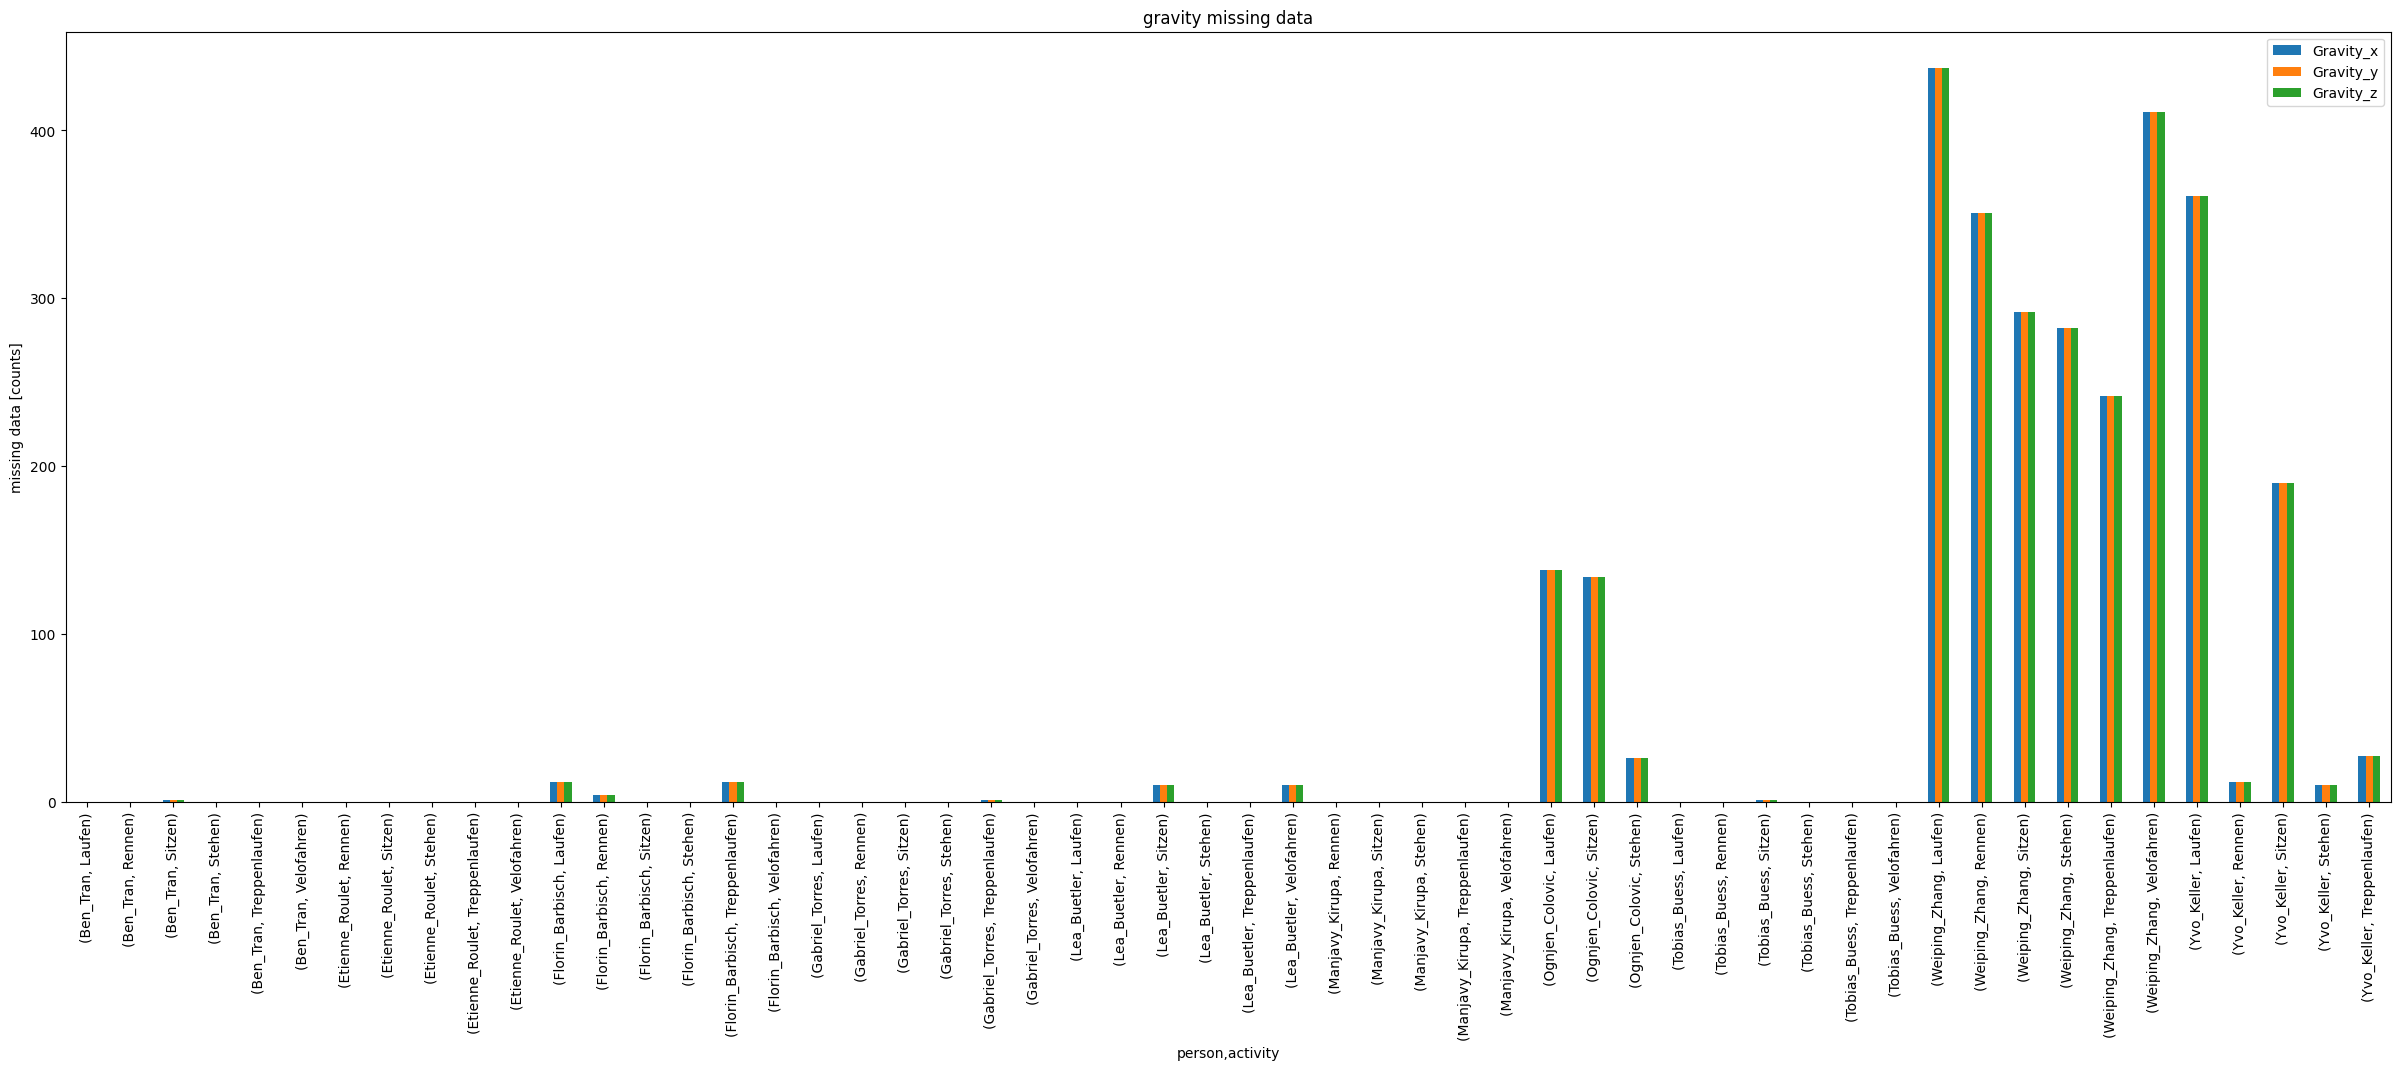

In [17]:
data[["Gravity_x", "Gravity_y", "Gravity_z"]].isnull().groupby([data["person"], data["activity"]]).sum().plot.bar(figsize=(30,10))
plt.title("gravity missing data")
plt.ylabel("missing data [counts]")
plt.show()

In [18]:
#missing data in % as table
100*(data[["Gravity_x"]].isnull().groupby([data["person"], data["activity"]]).sum() / data[["Gravity_x"]].groupby([data["person"], data["activity"]]).count()).rename(columns={"Gravity_x": "missing data"})

missing data
person          activity                   
Ben_Tran        Laufen             0.000000
                Rennen             0.000000
                Sitzen             0.000514
                Stehen             0.000000
                Treppenlaufen      0.000000
                Velofahren         0.000000
Etienne_Roulet  Rennen             0.000000
                Sitzen             0.000000
                Stehen             0.000000
                Treppenlaufen      0.000000
                Velofahren         0.000000
Florin_Barbisch Laufen             0.014798
                Rennen             0.006268
                Sitzen             0.000000
                Stehen             0.000000
                Treppenlaufen      0.019256
                Velofahren         0.000000
Gabriel_Torres  Laufen             0.000000
                Rennen             0.000000
                Sitzen             0.000000
                Stehen             0.000000
                Treppenlaufen      0.001294
                Velofahren         0.000000
Lea_Buetler     Laufen             0.000000
                Rennen             0.000000
                Sitzen             0.010649
                Stehen             0.000000
                Treppenlaufen      0.000000
                Velofahren         0.011359
Manjavy_Kirupa  Rennen             0.000000
                Sitzen             0.000000
                Stehen             0.000000
                Treppenlaufen      0.000000
                Velofahren         0.000000
Ognjen_Colovic  Laufen             0.097852
                Sitzen             0.110062
                Stehen             0.118419
Tobias_Buess    Laufen             0.000000
                Rennen             0.000000
                Sitzen             0.001199
                Stehen             0.000000
                Treppenlaufen      0.000000
                Velofahren         0.000000
Weiping_Zhang   Laufen             0.309424
                Rennen             0.308723
                Sitzen             0.324239
                Stehen             0.320965
                Treppenlaufen      0.315696
                Velofahren         0.307506
Yvo_Keller      Laufen             0.196179
                Rennen             0.185615
                Sitzen             0.200399
                Stehen             0.218436
                Treppenlaufen      0.187682

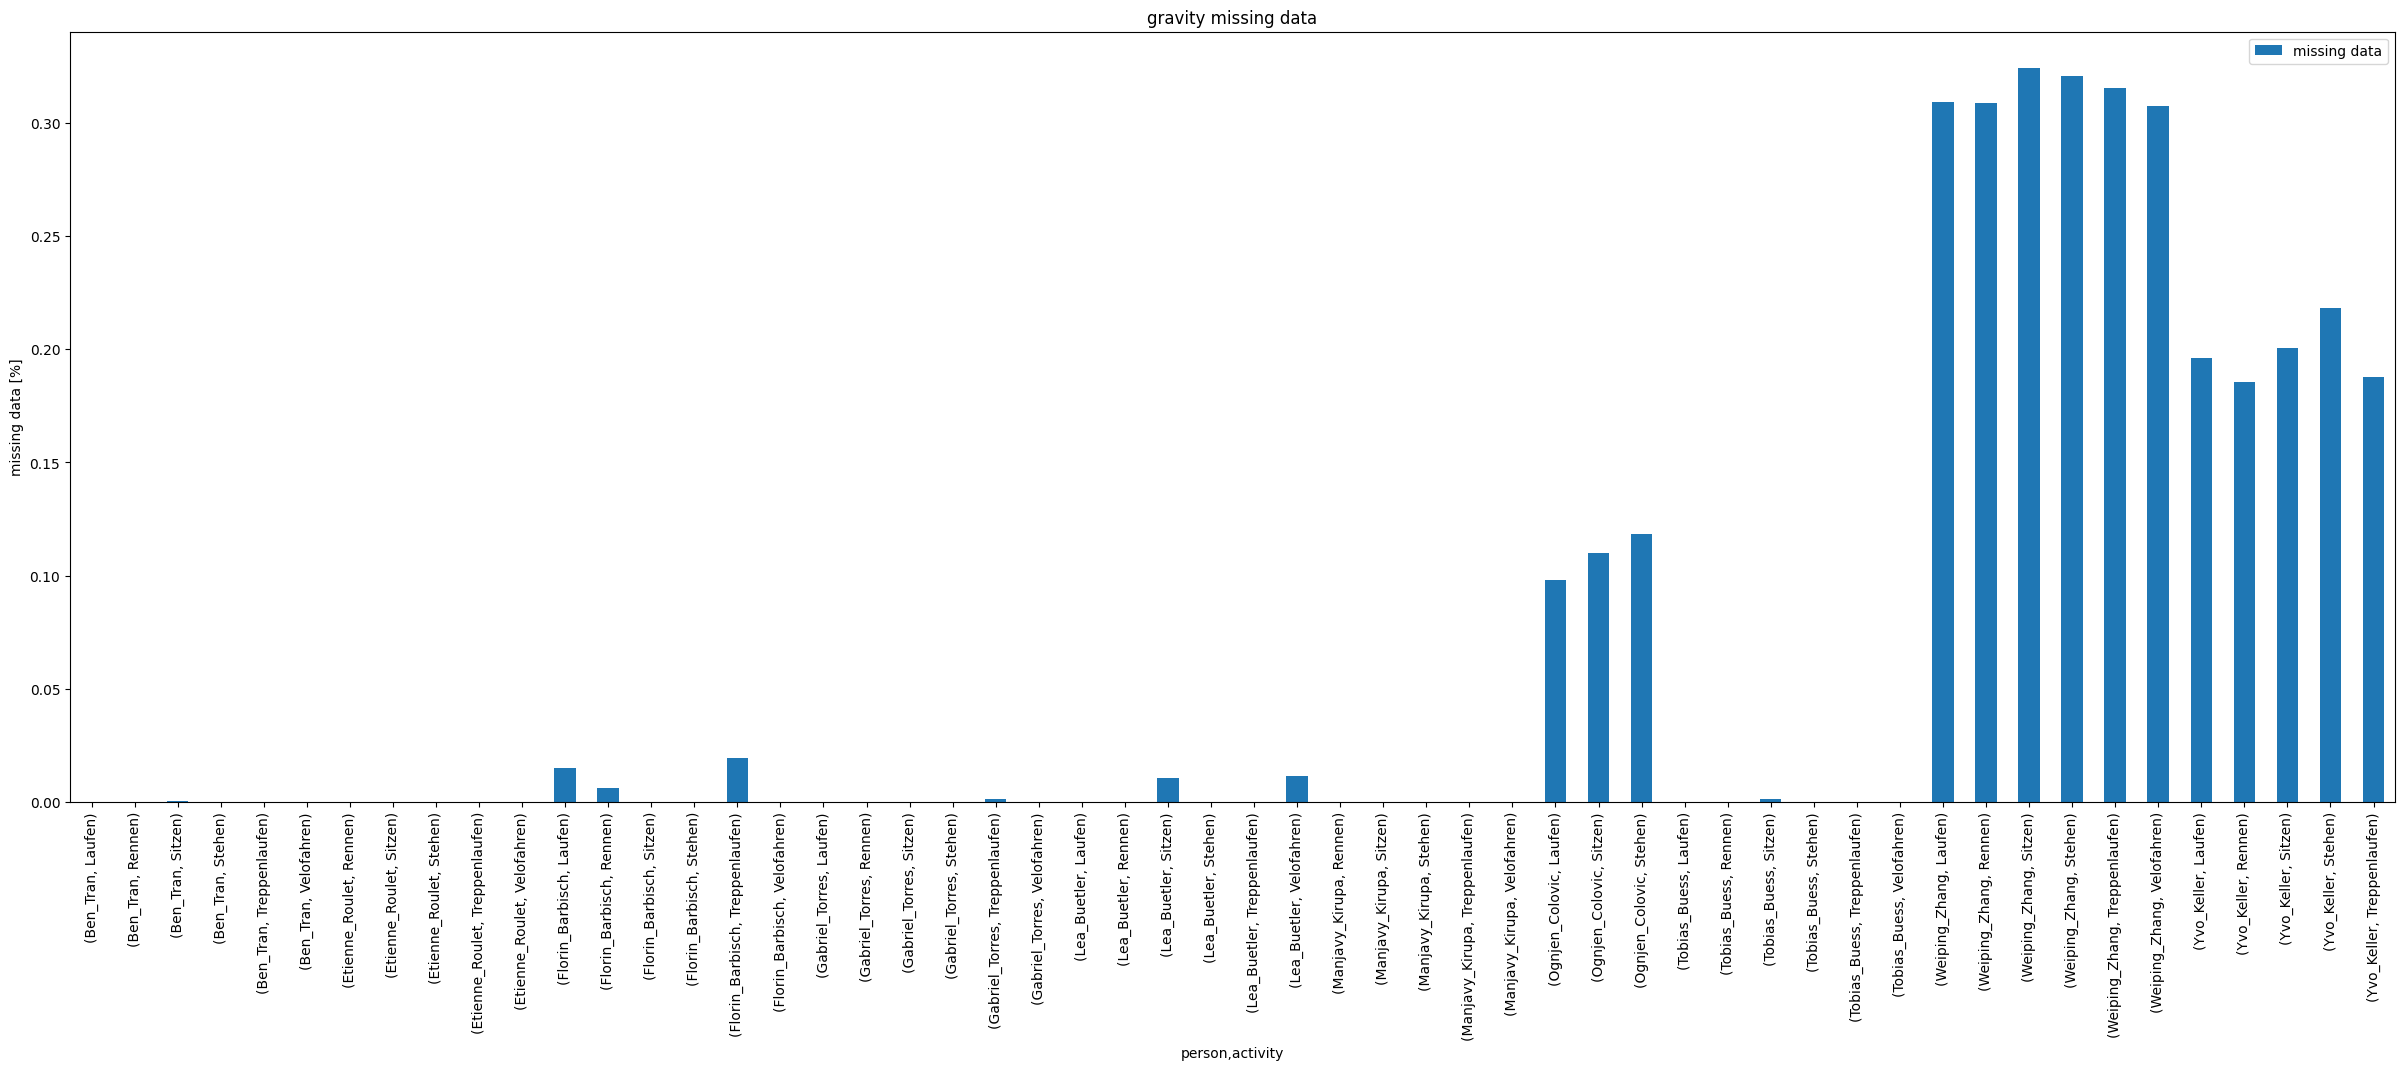

In [19]:
(100*(data[["Gravity_x"]].isnull().groupby([data["person"], data["activity"]]).sum() / data[["Gravity_x"]].groupby([data["person"], data["activity"]]).count())).rename(columns={"Gravity_x": "missing data"}).plot.bar(figsize=(30,10))
plt.title("gravity missing data")
plt.ylabel("missing data [%]")
plt.show()

# analyze raw data

C:\Users\tobia\AppData\Local\Temp\ipykernel_38540\3373432382.py:1: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for filename, df in get_person_activity("Tobias_Buess", "Laufen").groupby(["filename"]):


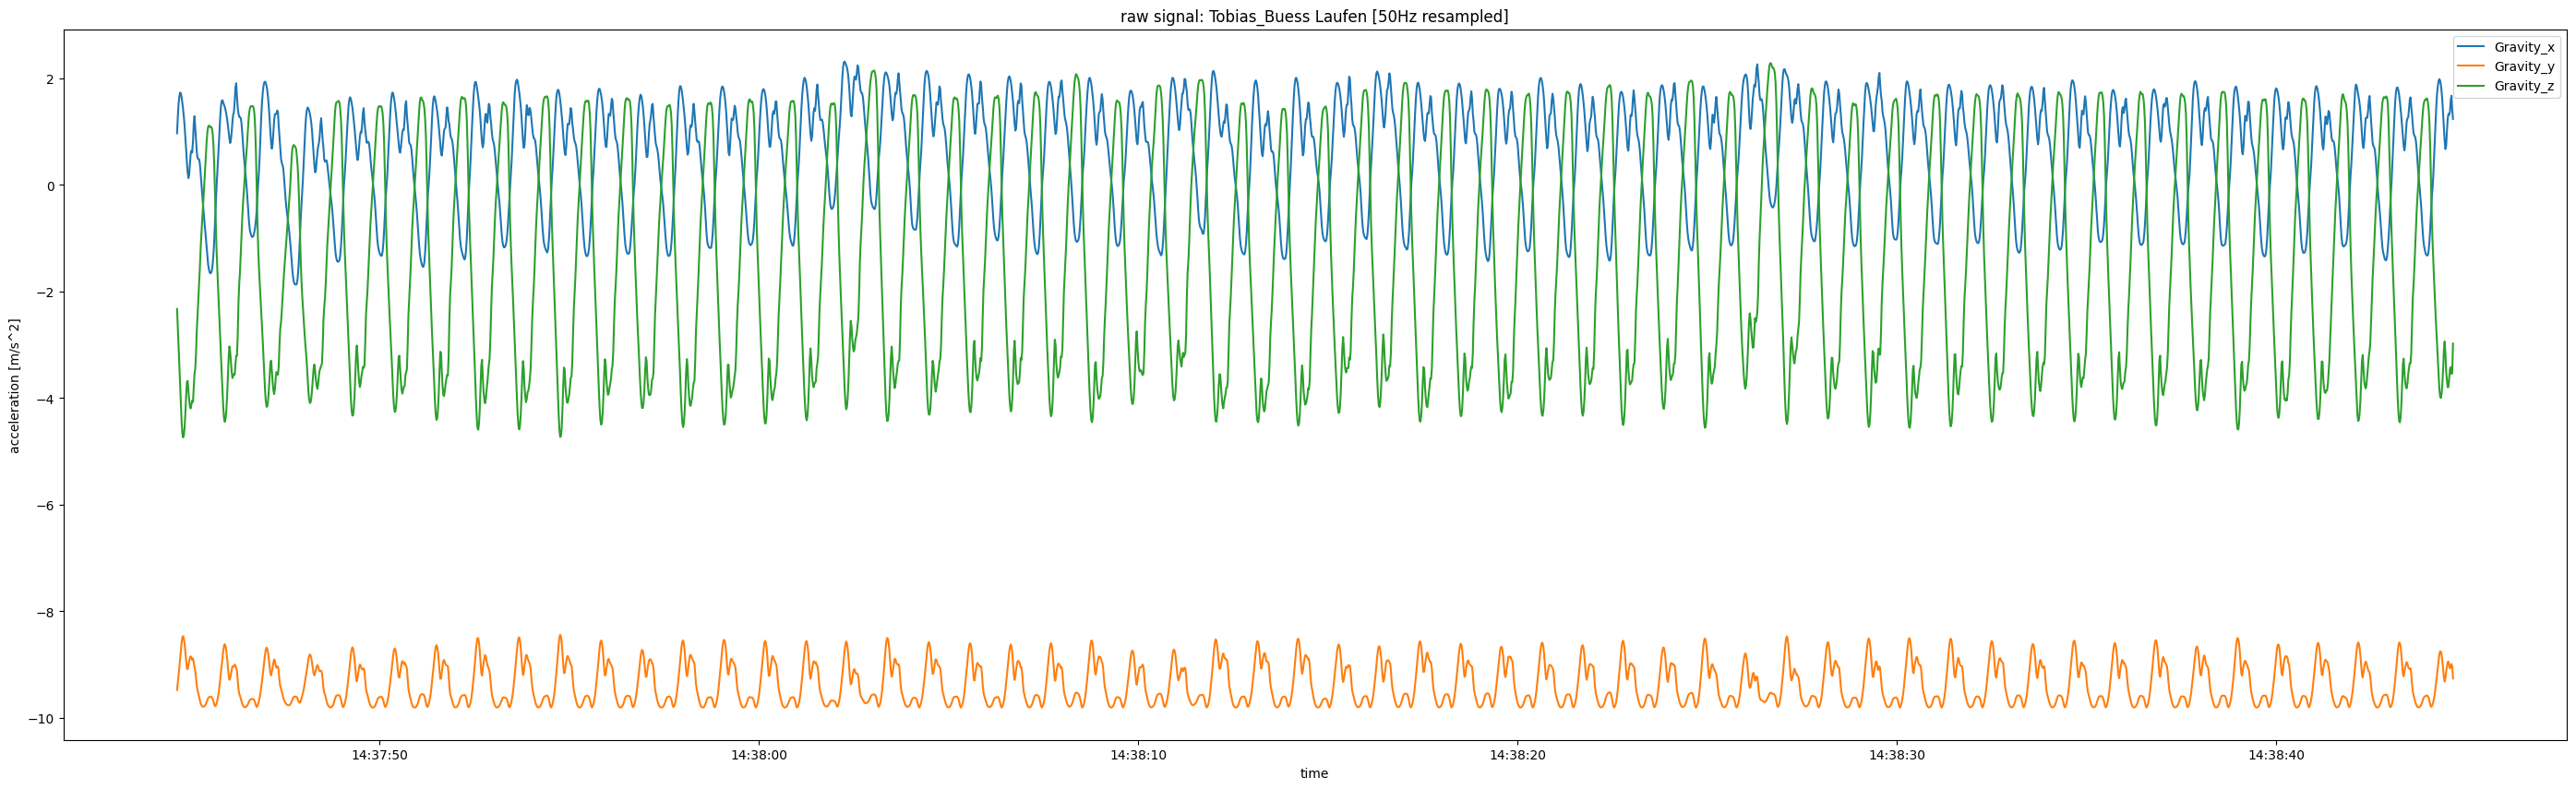

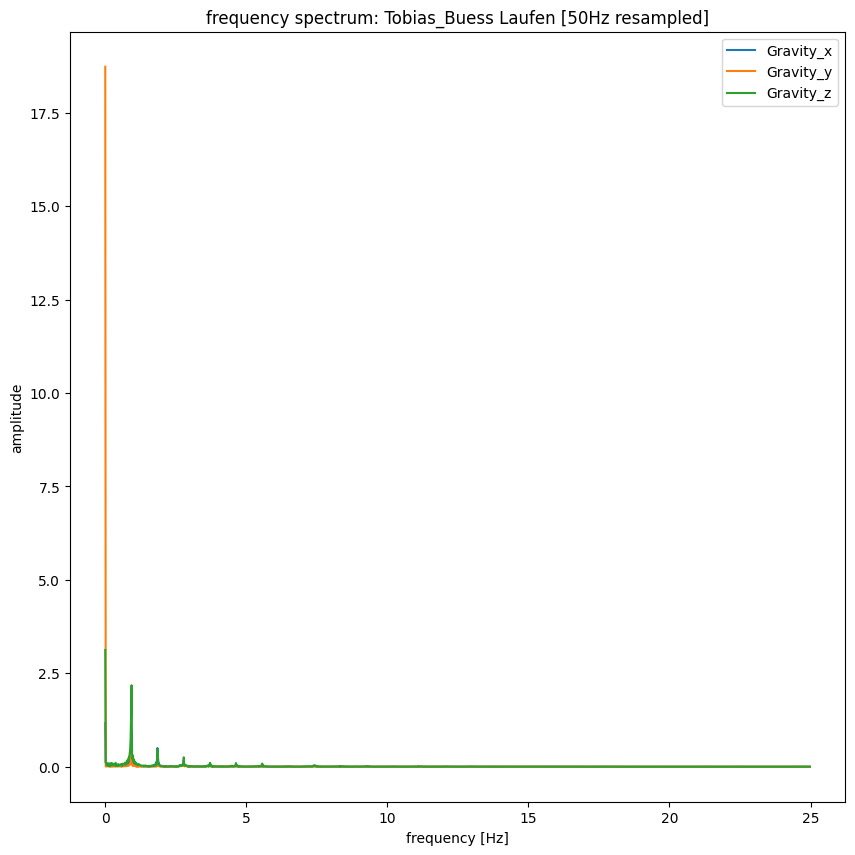

In [12]:
for filename, df in get_person_activity("Tobias_Buess", "Laufen").groupby(["filename"]):
    plot_trunc_res_gravity(df)

    break

C:\Users\tobia\AppData\Local\Temp\ipykernel_38540\2883353256.py:1: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for filename, df in get_person_activity("Tobias_Buess", "Laufen").groupby(["filename"]):


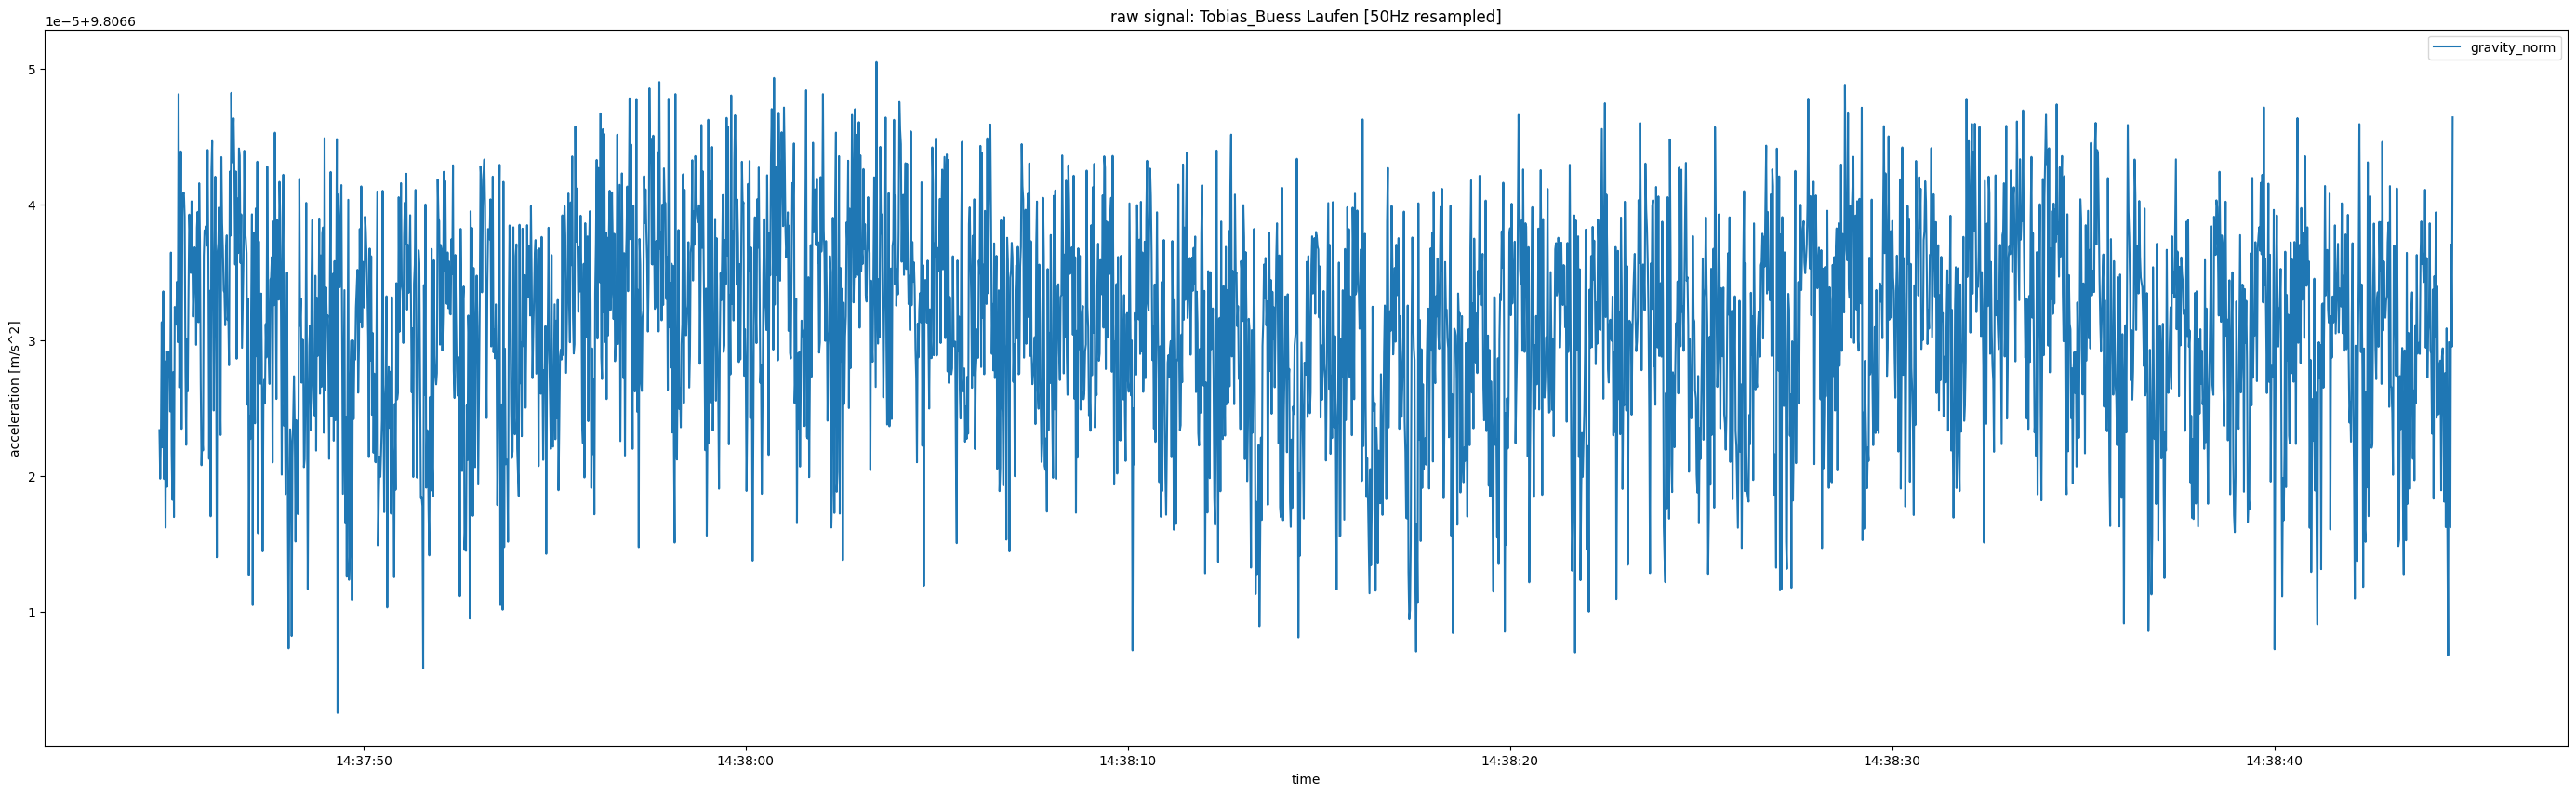

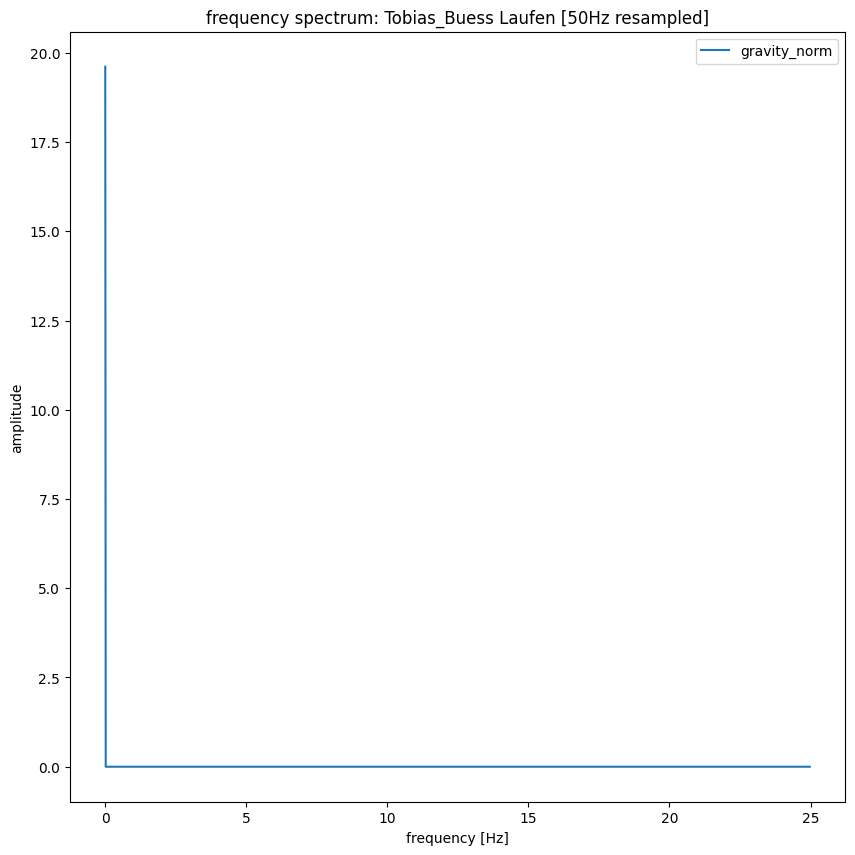

In [14]:
for filename, df in get_person_activity("Tobias_Buess", "Laufen").groupby(["filename"]):
    plot_trunc_res_gravtiy_norm(df)

    break

C:\Users\tobia\AppData\Local\Temp\ipykernel_38540\3697367613.py:1: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group, df in get_person("Tobias_Buess").groupby(["activity"]):


Laufen


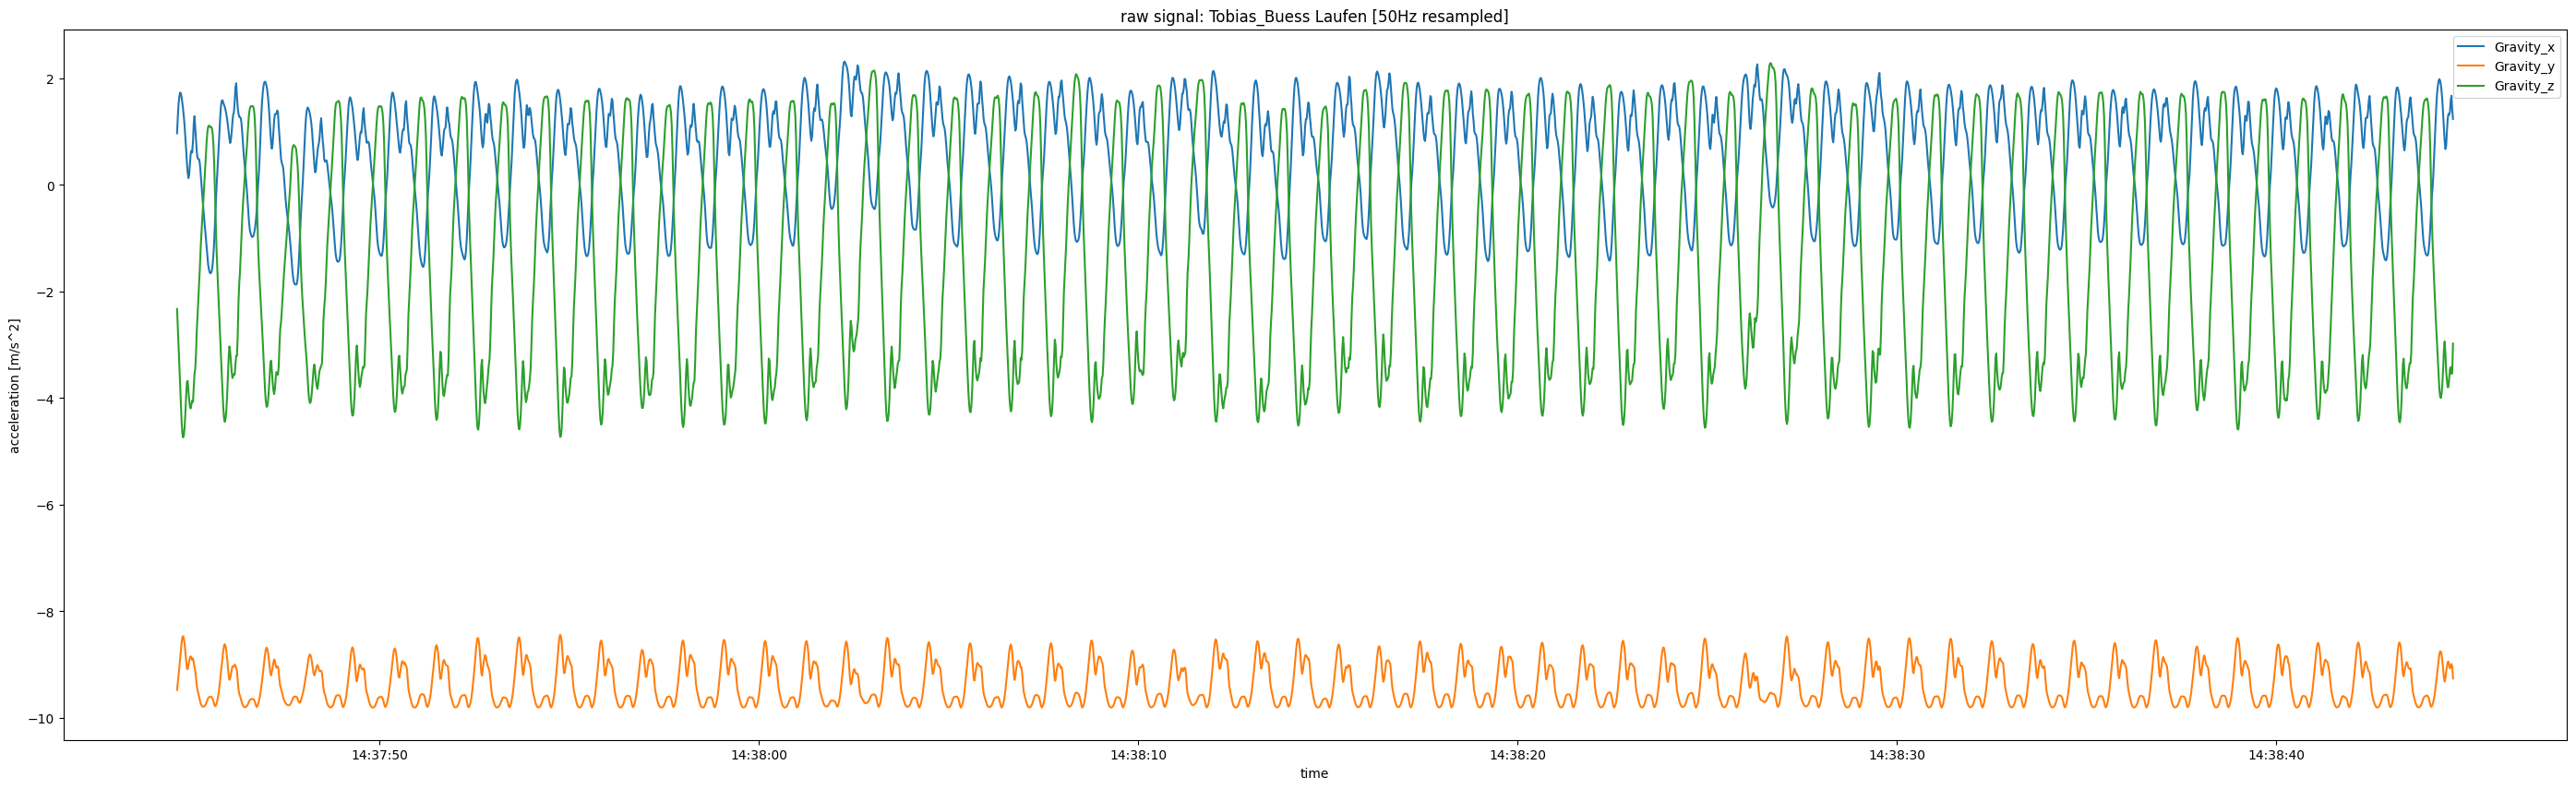

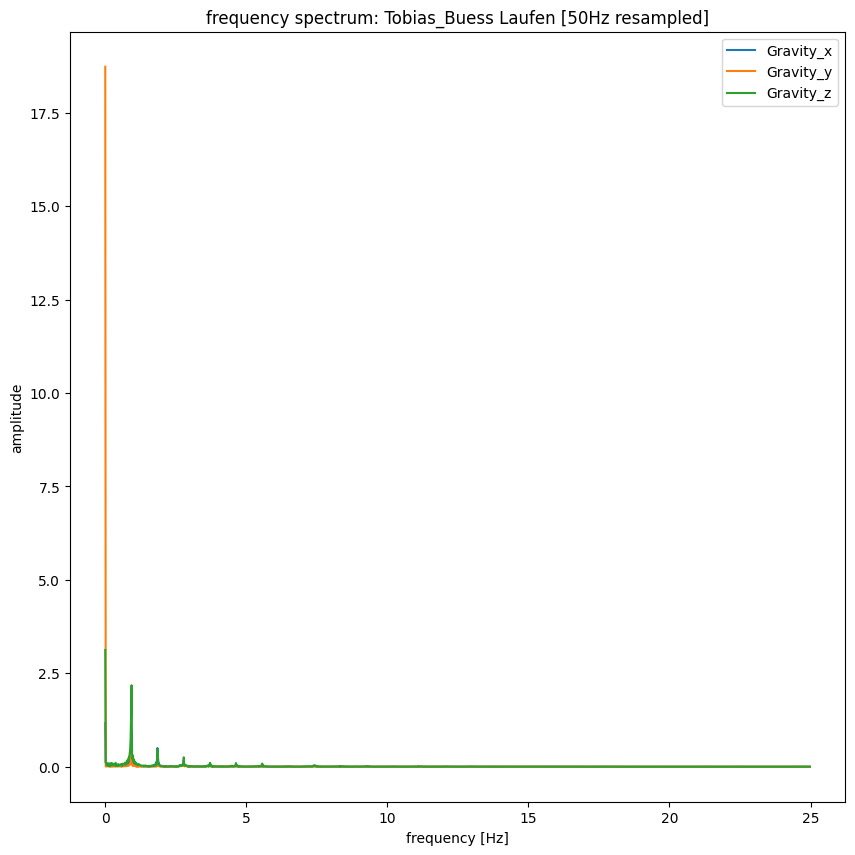

Rennen


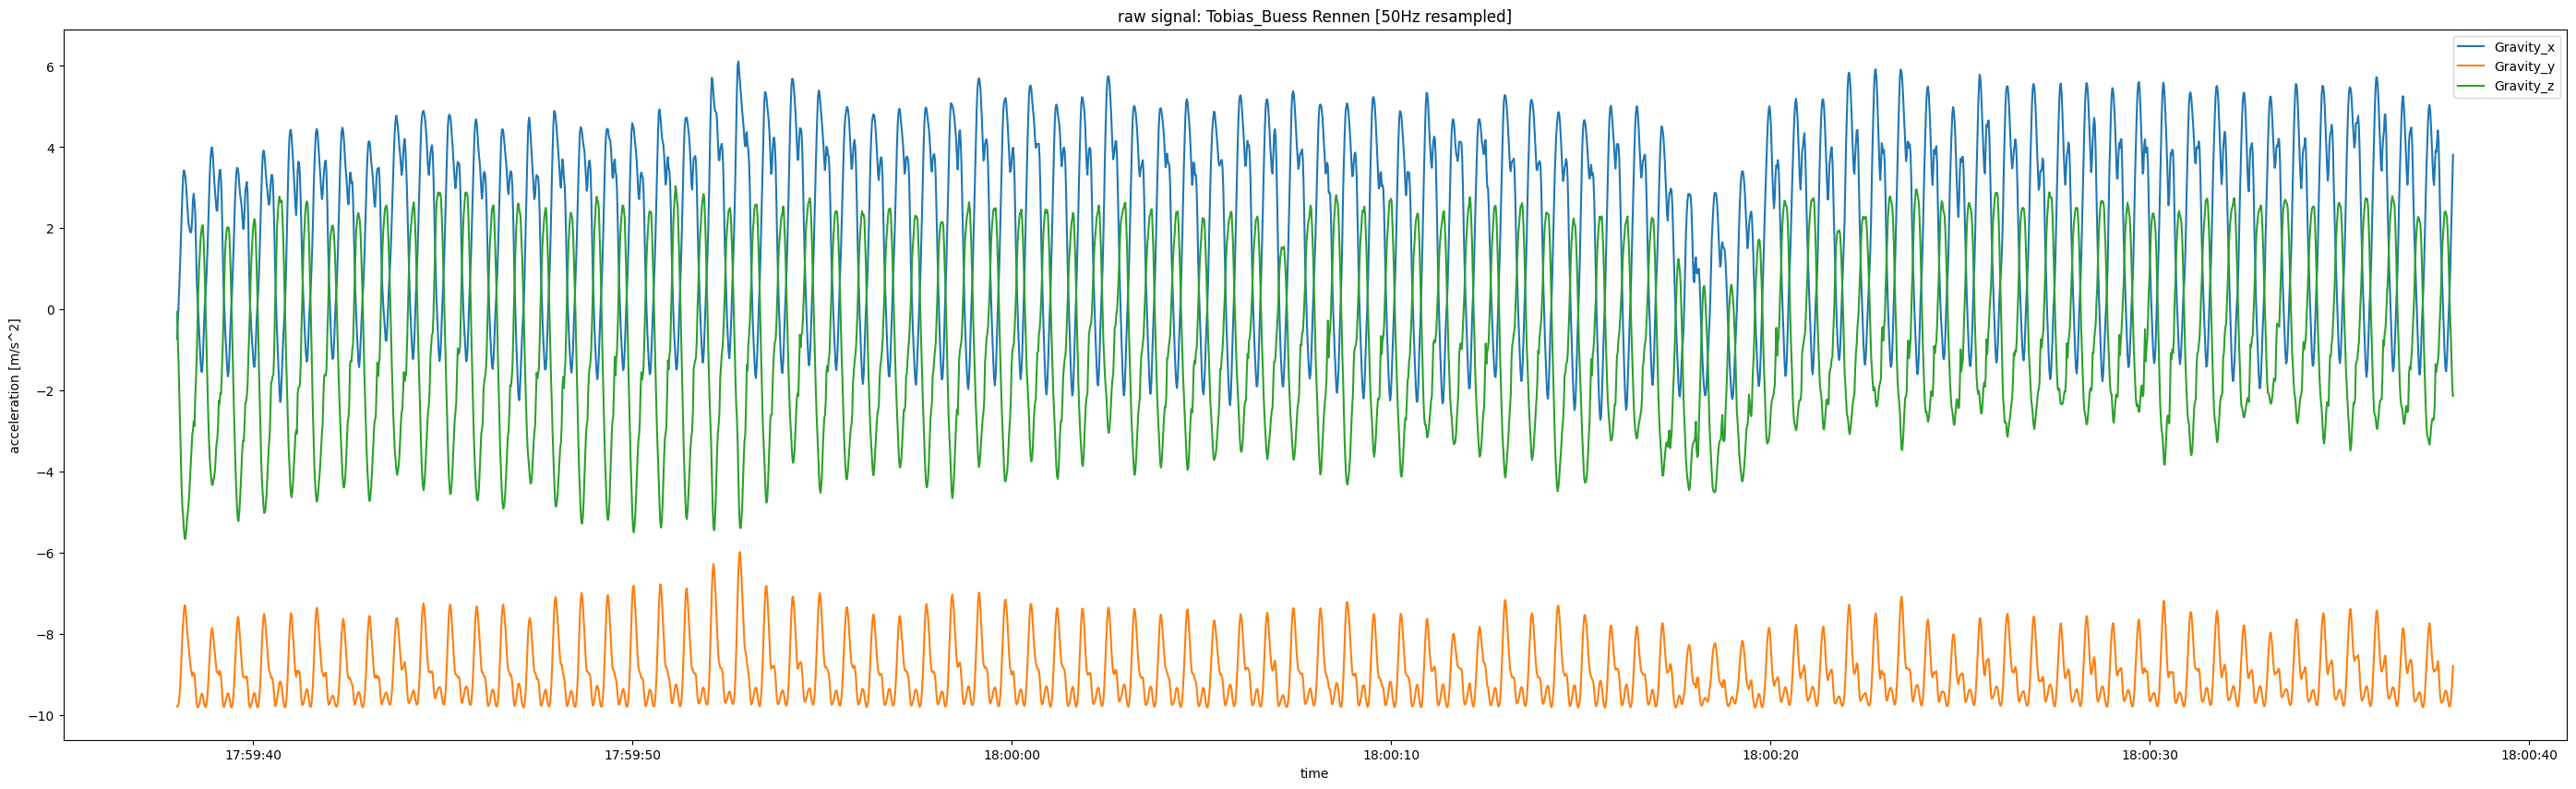

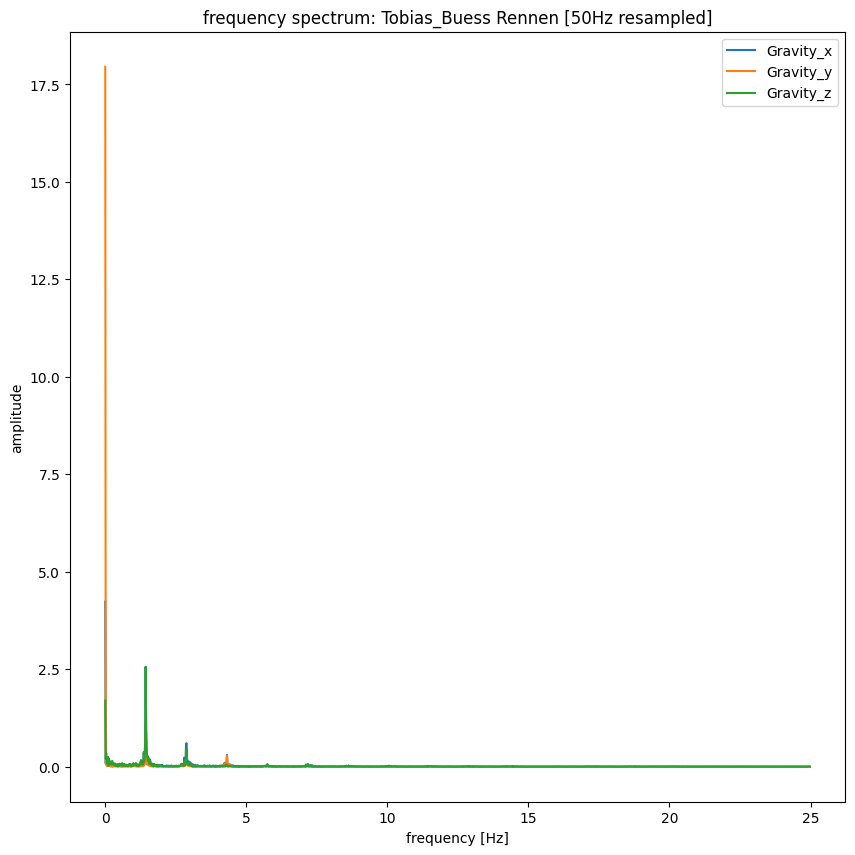

Sitzen


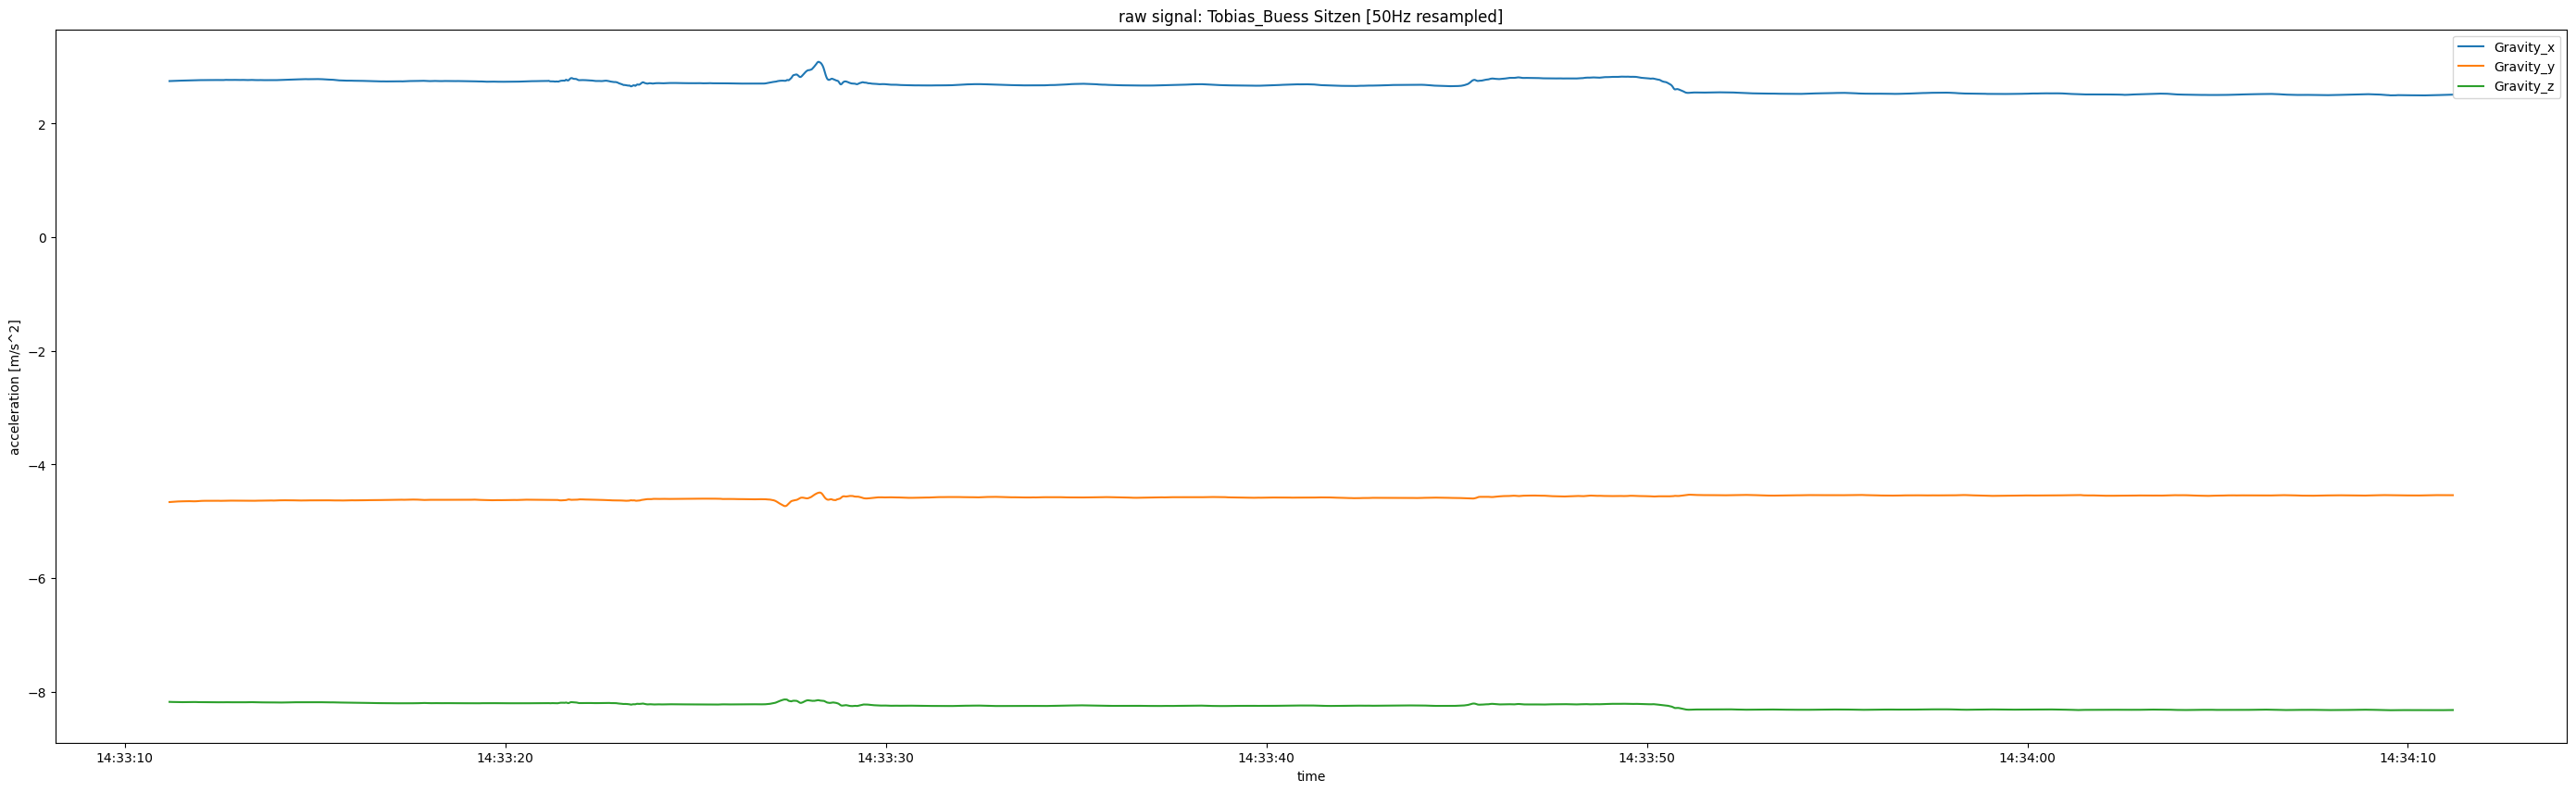

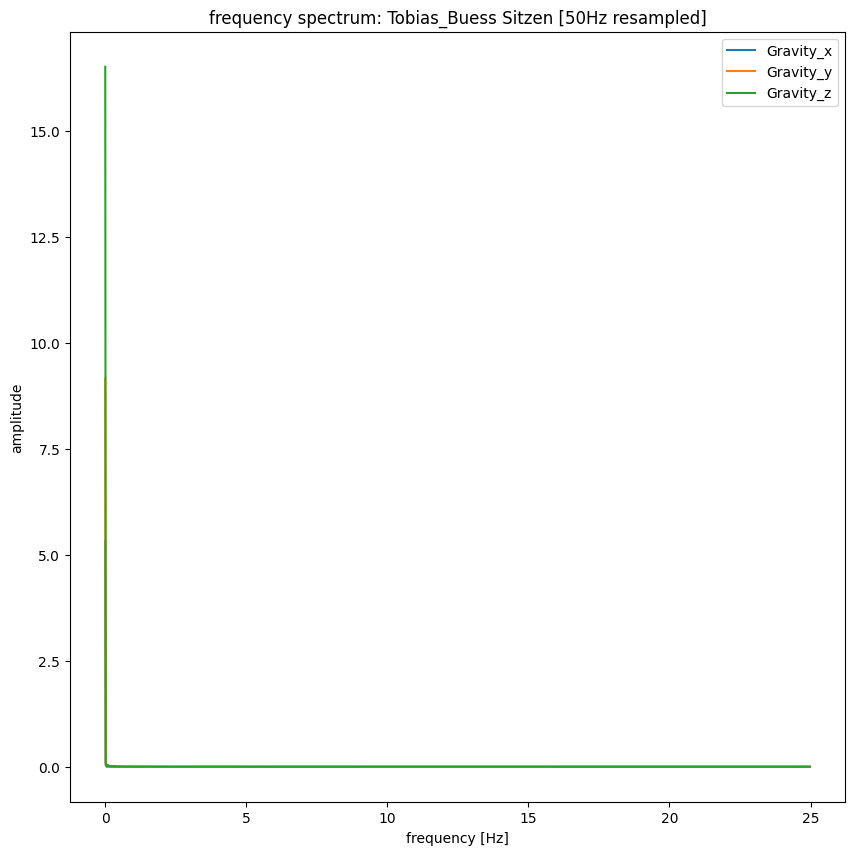

Stehen


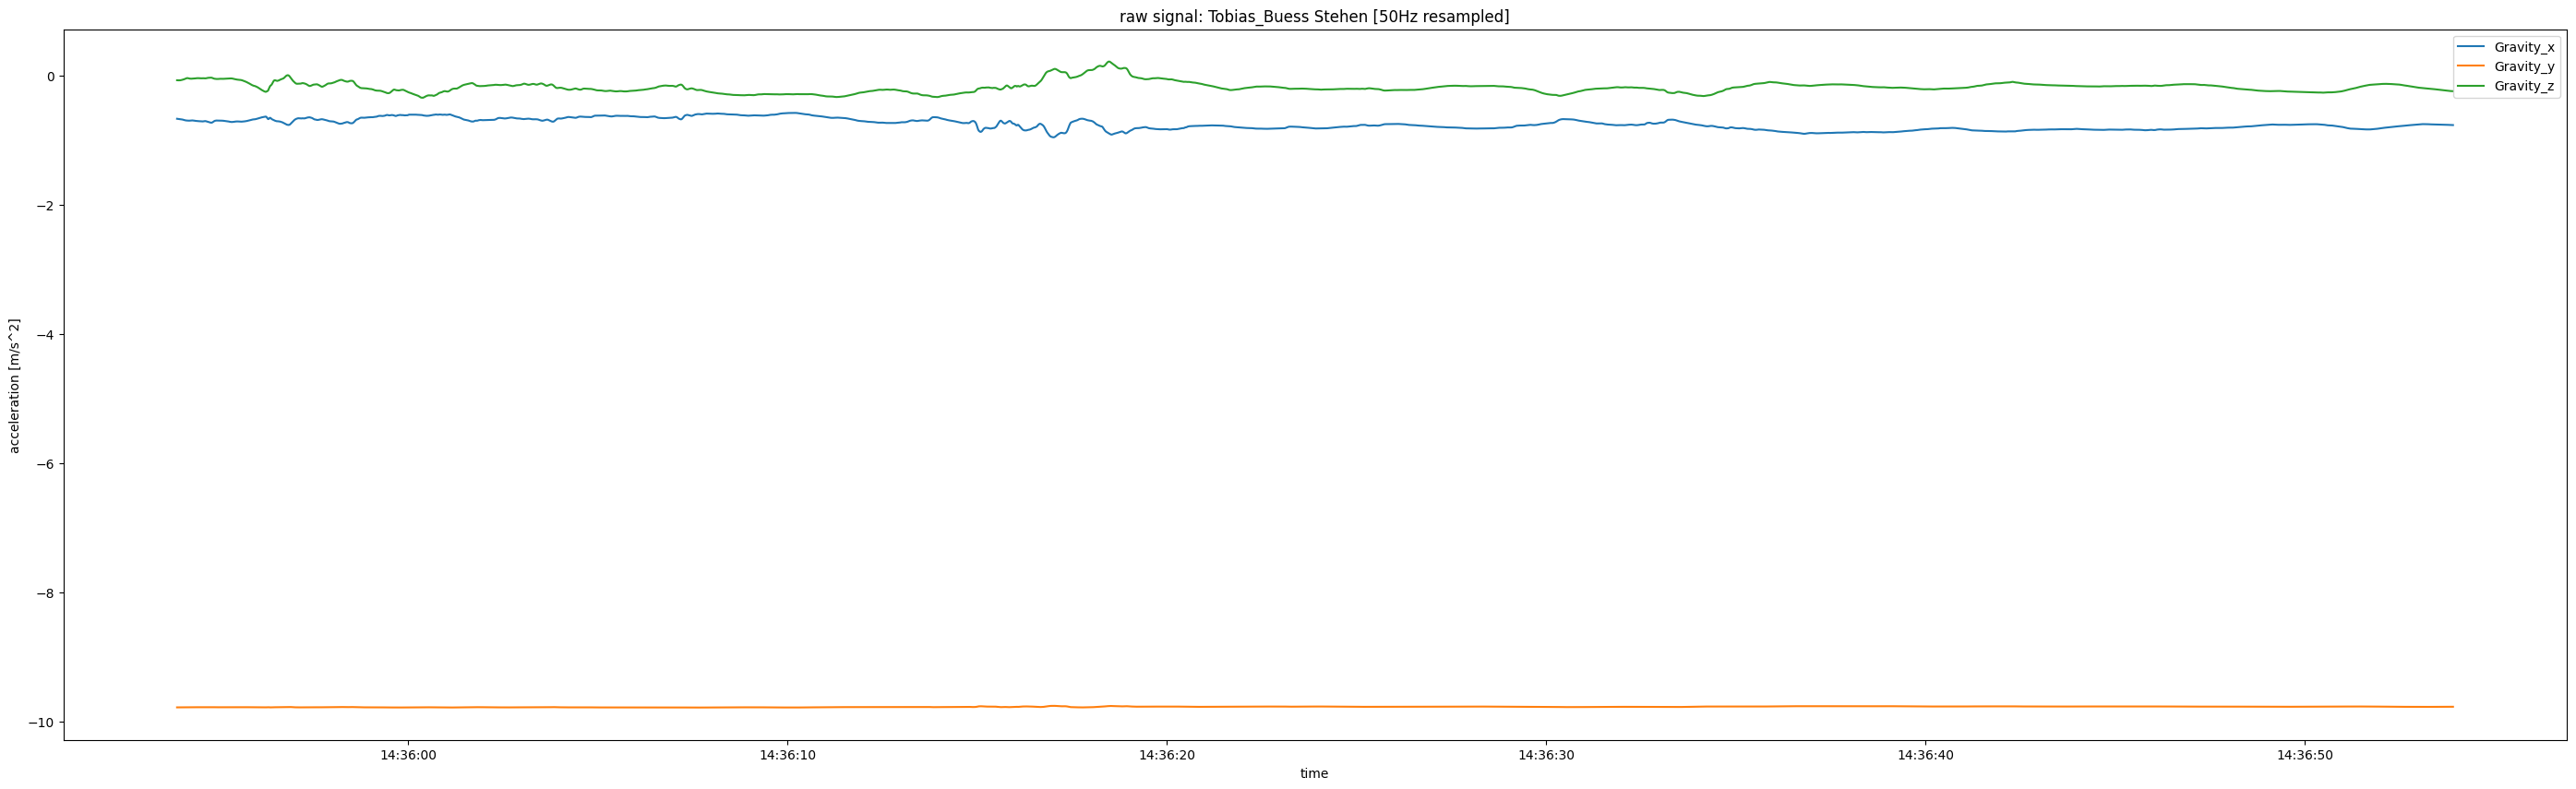

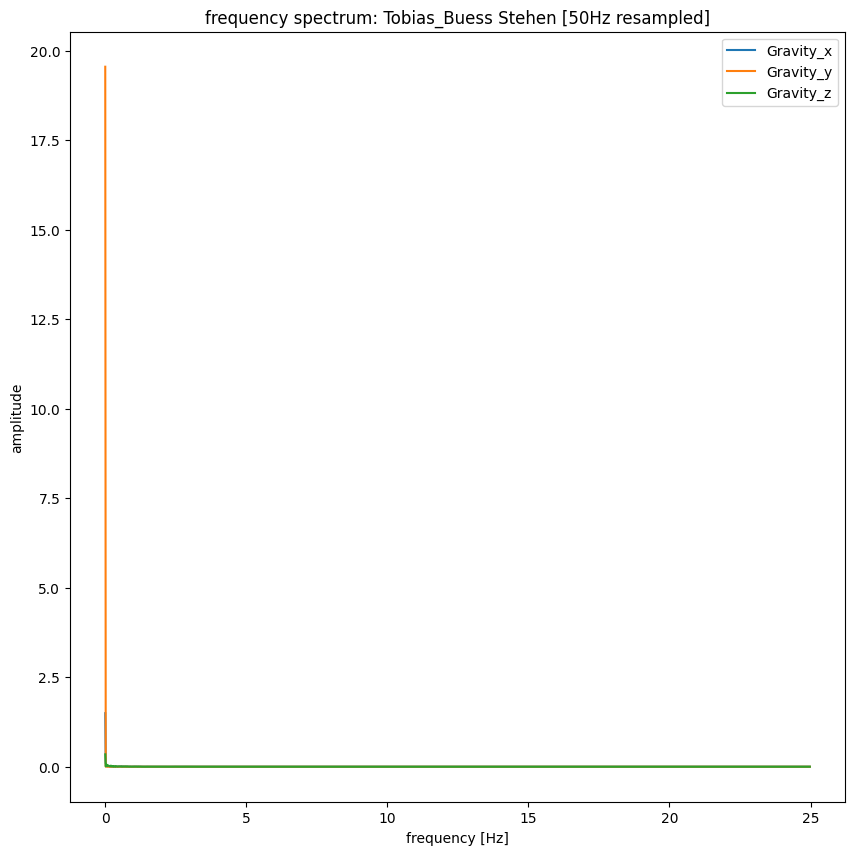

Treppenlaufen


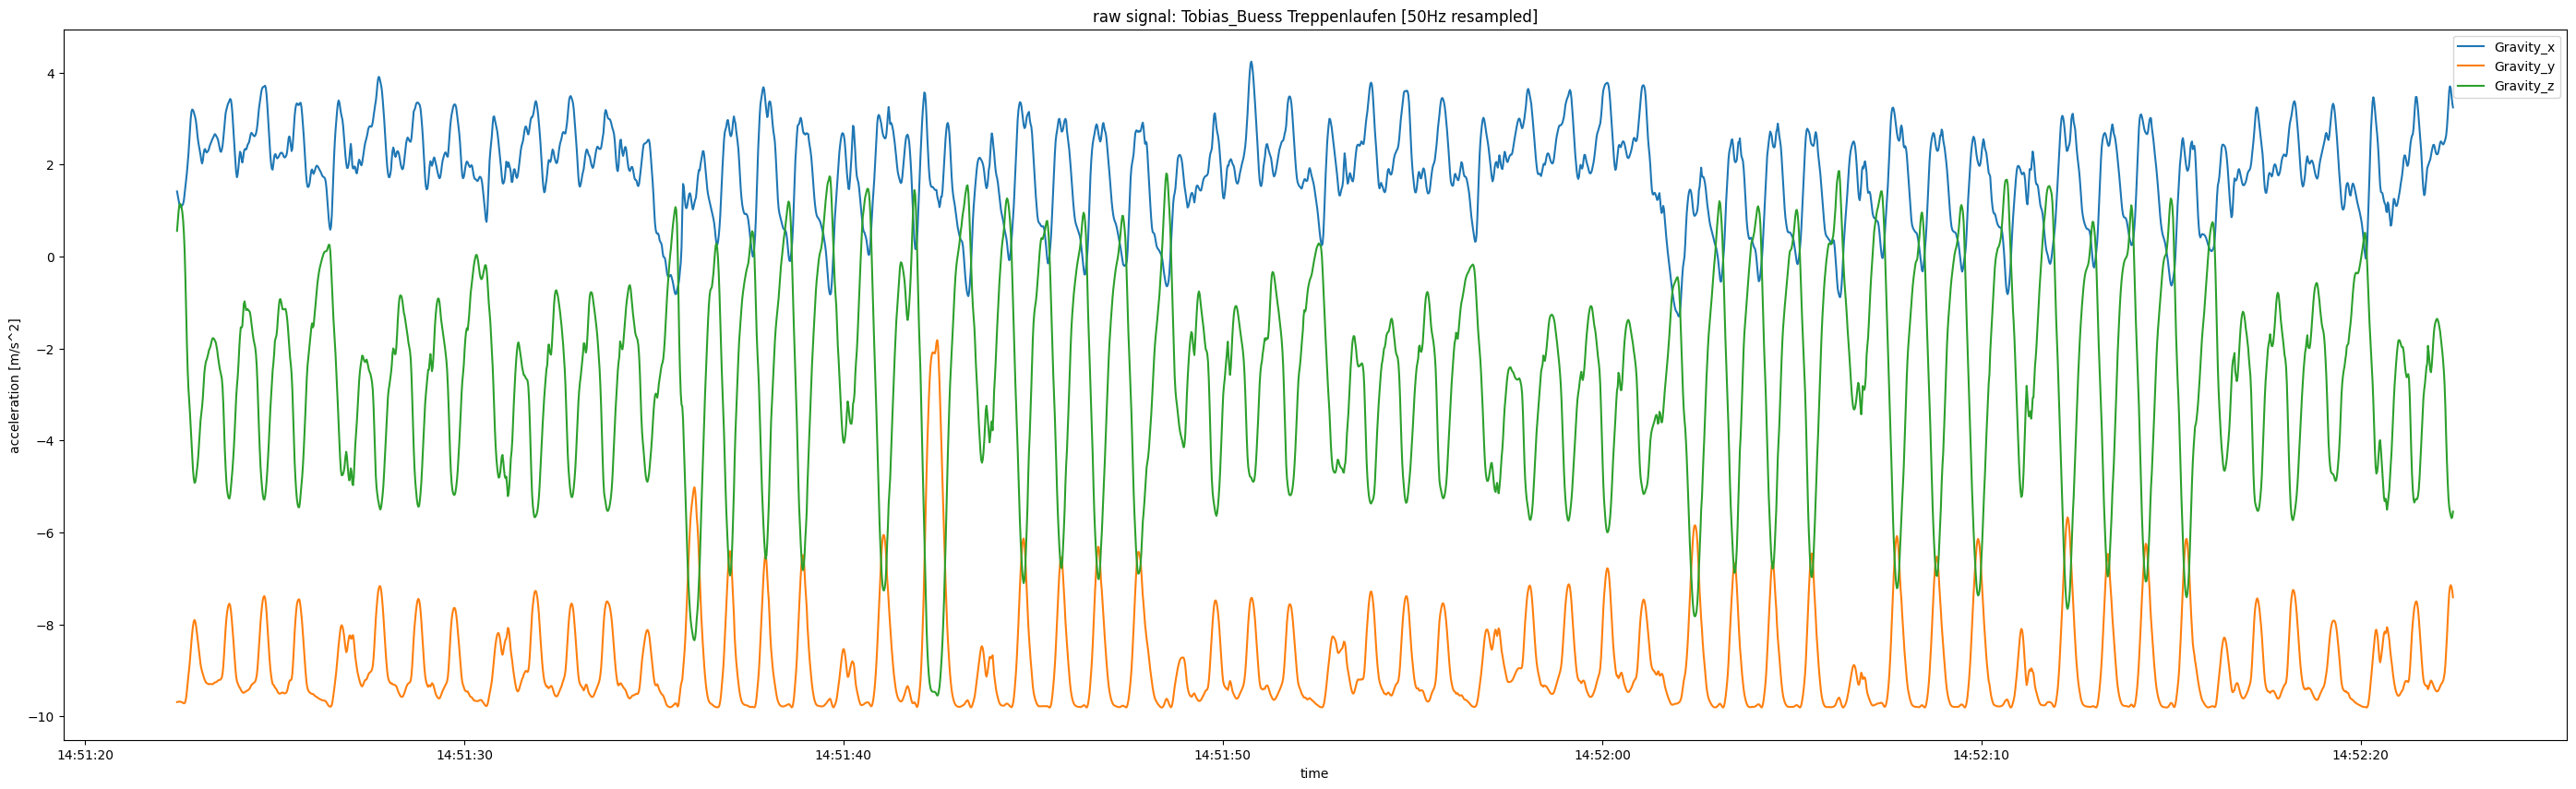

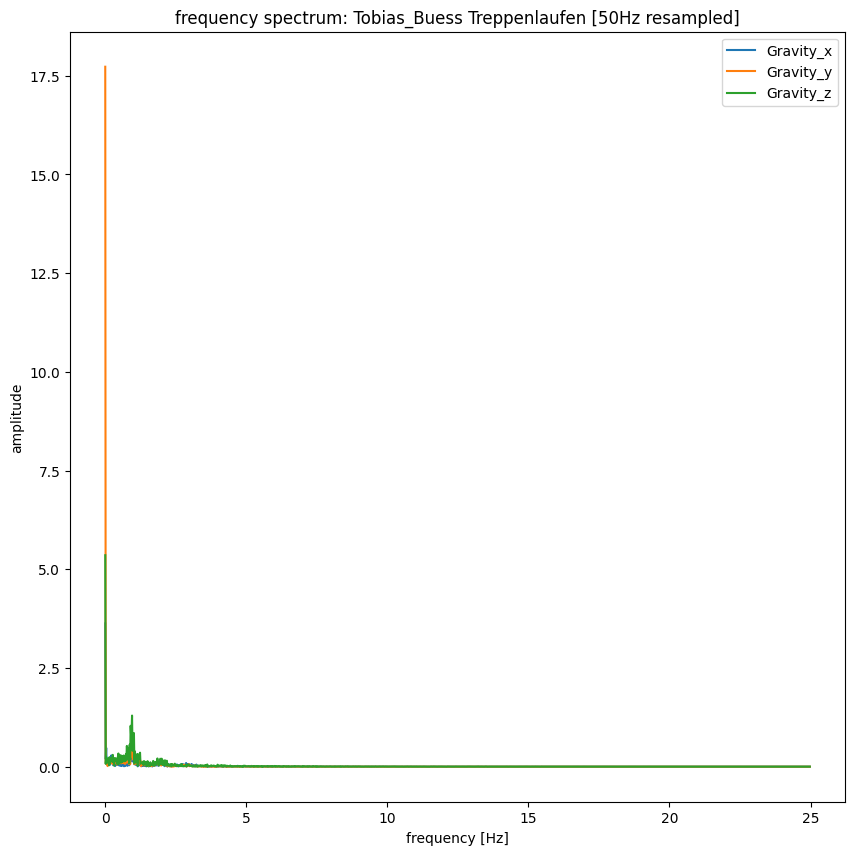

Velofahren


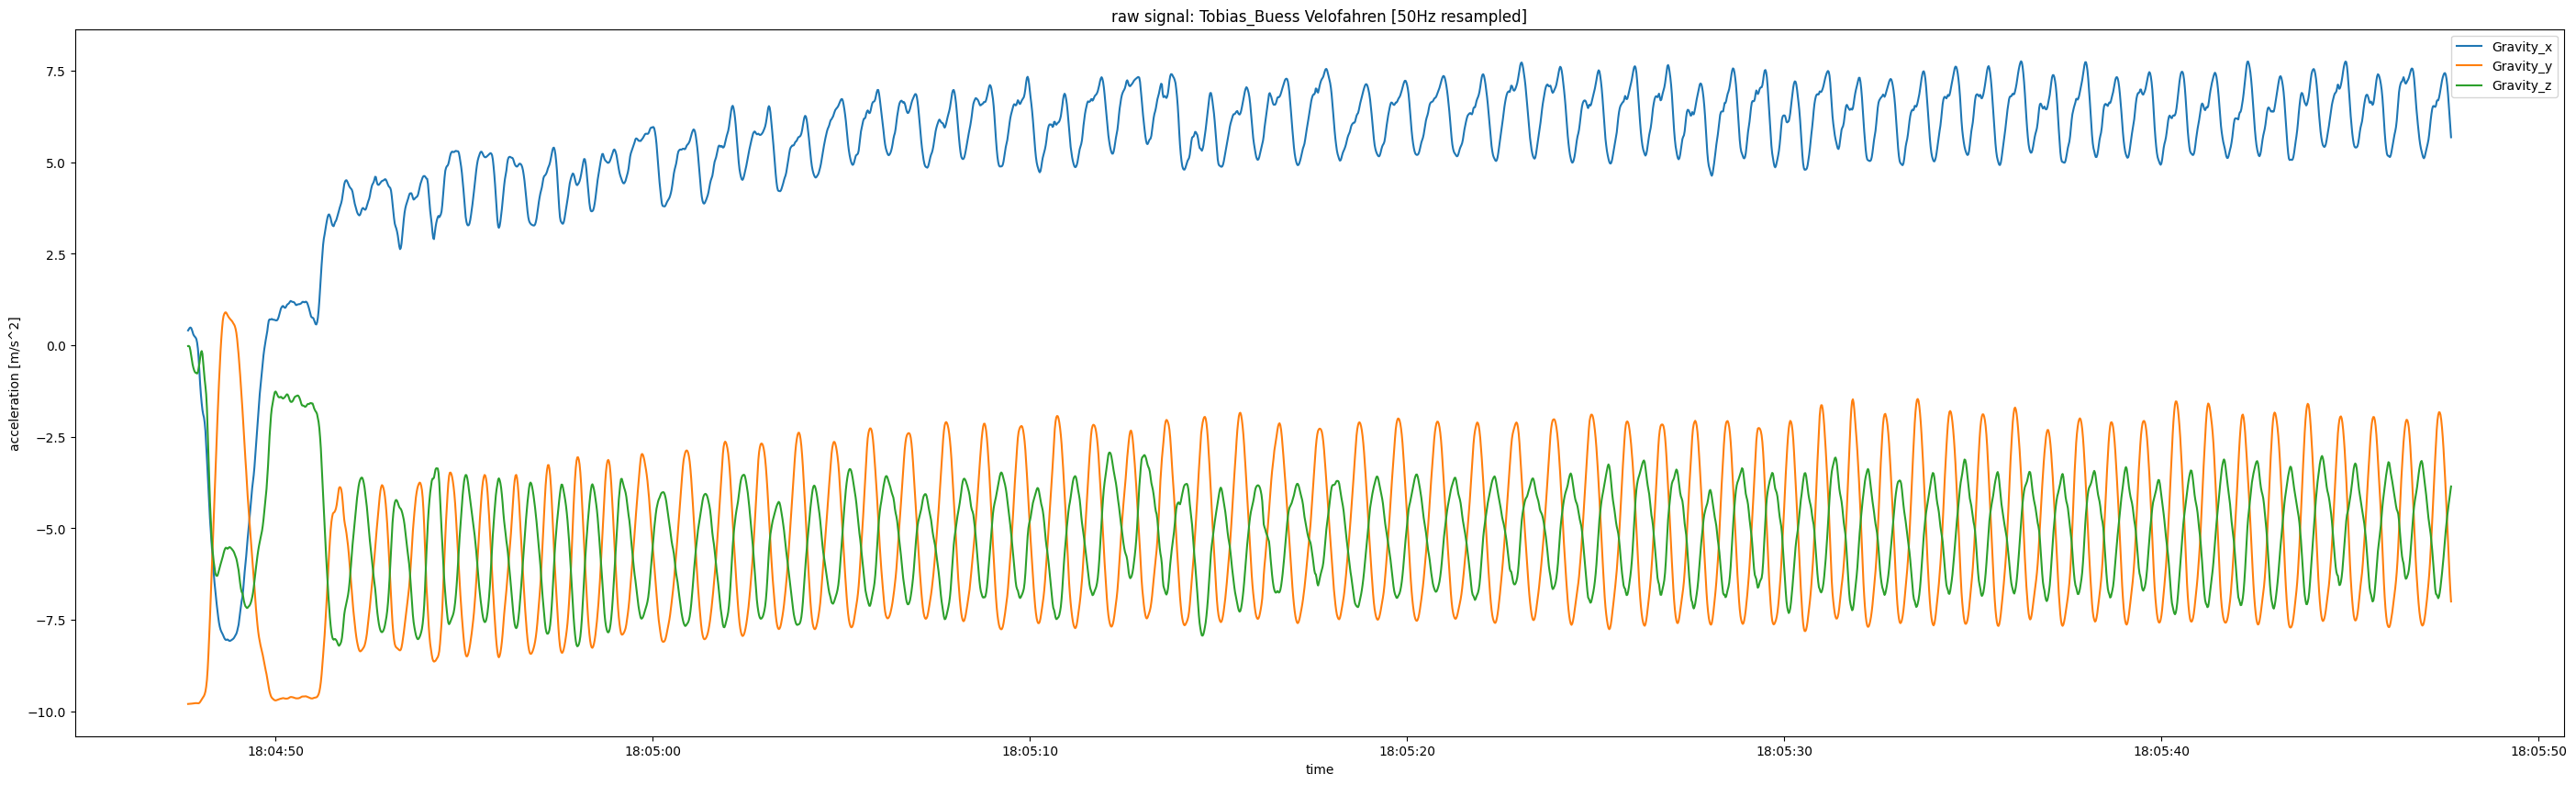

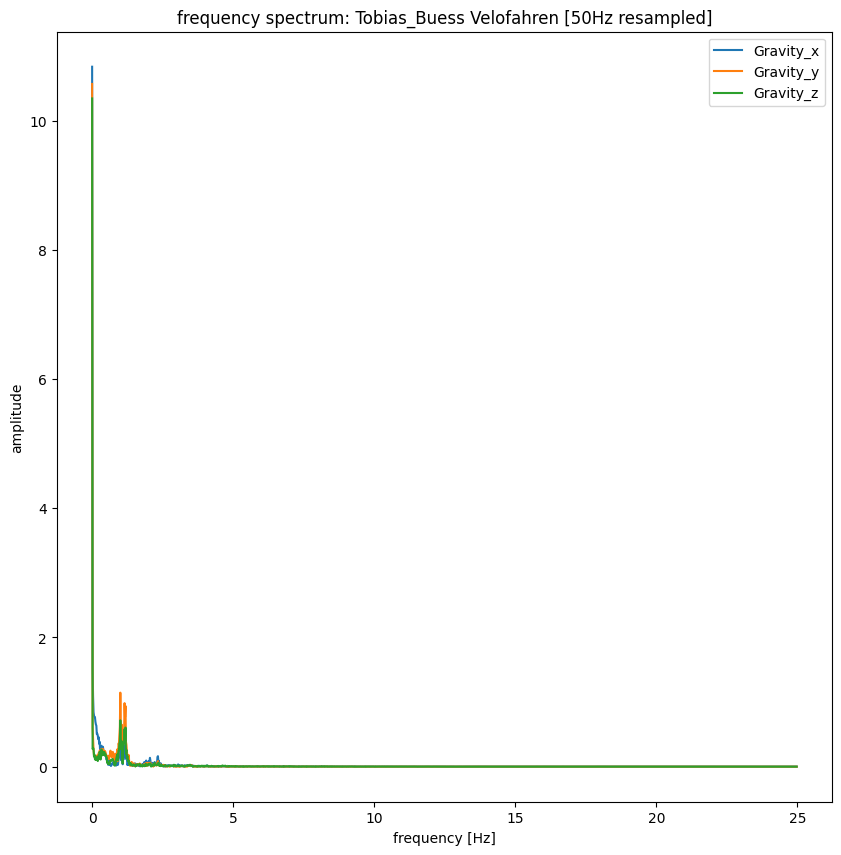

In [30]:
for group, df in get_person("Tobias_Buess").groupby(["activity"]):
    print(group)
    plot_trunc_res_gravity(df.groupby("hash").get_group(df.iloc[0]["hash"]))